In [ ]:
!nvidia-smi

Sat Jul 22 12:19:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls '/content/drive/MyDrive/cars_detection'

 labelsvid_4_1000.txt    training_images/
 sample_submission.csv  'train_solution_bounding_boxes (1).csv'
 testing_images/


In [ ]:
import torch
from torch.utils.data import random_split, Dataset, DataLoader
import numpy as np
from PIL import Image
import os, pandas as pd, cv2
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict
import shutil
import yaml, json
from sklearn.model_selection import train_test_split


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/cars_detection/train_solution_bounding_boxes (1).csv')
df.head()

image        xmin        ymin        xmax        ymax
0   vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547
1  vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180
2  vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180
3  vid_4_10020.jpg  496.483358  172.363256  630.020260  231.539575
4  vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422

In [ ]:
df.shape

(559, 5)

In [ ]:
len(np.unique(df['image']))

355

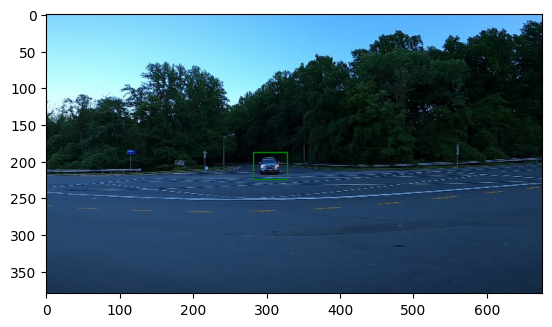

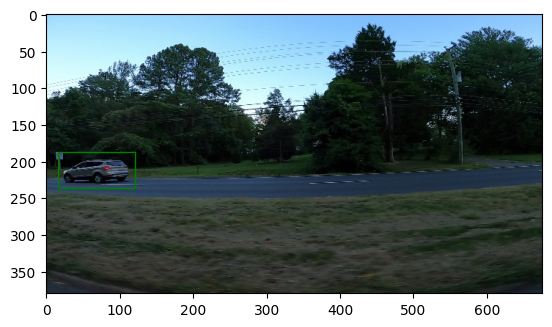

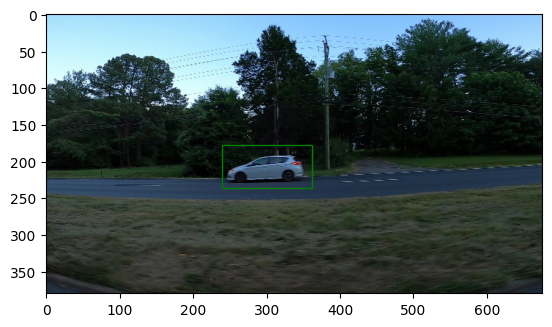

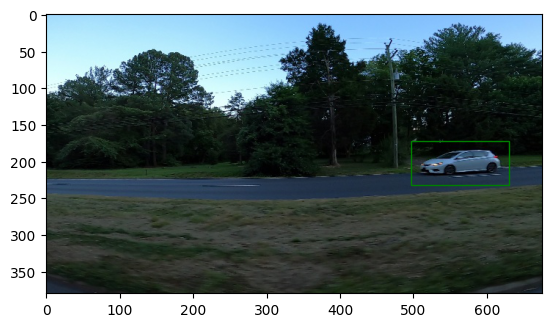

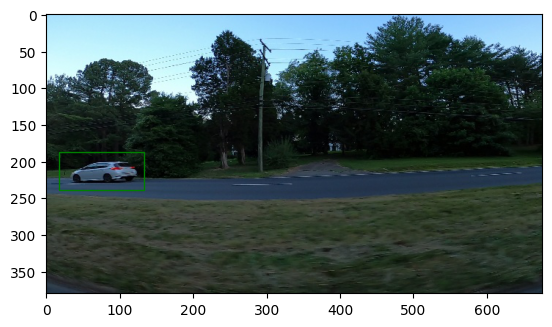

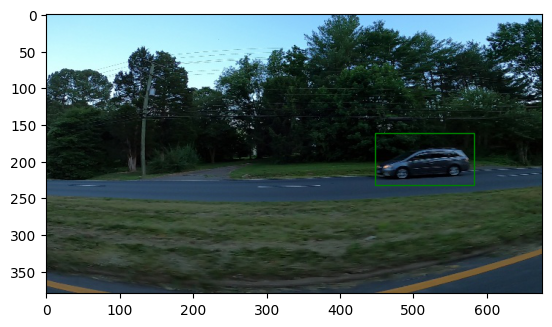

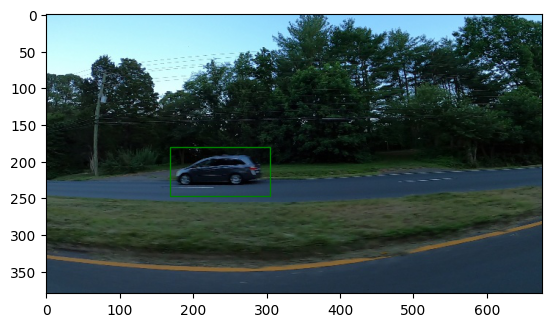

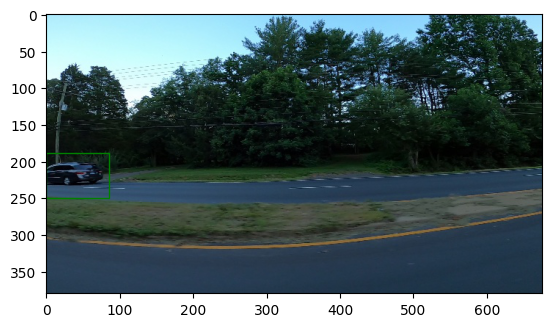

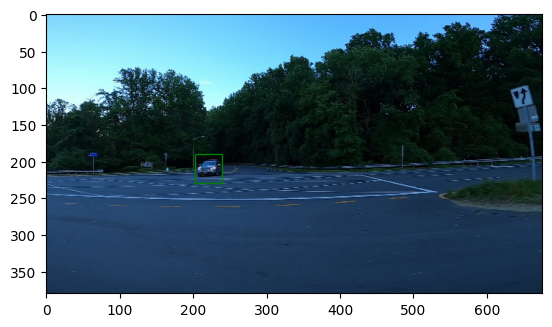

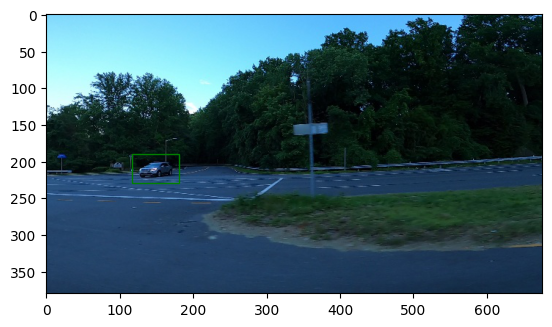

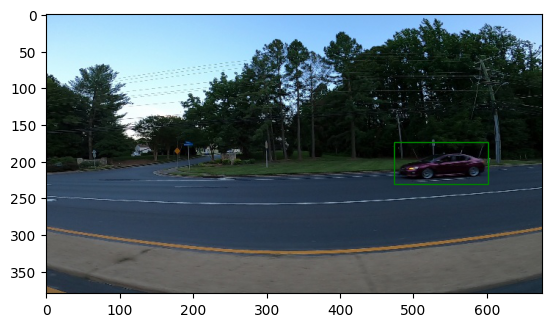

In [ ]:
from pandas.core.frame import Axis
for i in df.index:
    path = '/content/drive/MyDrive/cars_detection/training_images/'

    img = Image.open(path + str(df['image'][i]))
    x_min = df['xmin'][i]
    y_min = df['ymin'][i]
    width = df['xmax'][i] - df['xmin'][i]
    height = df['ymax'][i]- df['ymin'][i]
    fig, ax = plt.subplots()
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='g', facecolor='none')
    ax.add_patch(rect)
    ax.imshow(img)
    plt.show()
    if i == 10:
        break

In [ ]:
for i in df.index:
    img = cv2.imread(path + str(df['image'][i]))
    print(img.shape)
    if i == 10:
        break

(380, 676, 3)
(380, 676, 3)
(380, 676, 3)
(380, 676, 3)
(380, 676, 3)
(380, 676, 3)
(380, 676, 3)
(380, 676, 3)
(380, 676, 3)
(380, 676, 3)
(380, 676, 3)


In [ ]:

HEIGHT = 380
WIDTH = 676

def bounding_box(xmin,ymin,xmax,ymax):
    center = ((xmin+xmax)/2, (ymin+ymax)/2)
    x_center = center[0] / WIDTH
    y_center = center[1] / HEIGHT
    height = (ymax - ymin)/HEIGHT
    width = (xmax - xmin)/WIDTH
    return x_center, y_center, height, width

In [ ]:
HEIGHT = 380
WIDTH = 676

def bounding_box(xmin,ymin,xmax,ymax):
    center = ((xmin+xmax)/2, (ymin+ymax)/2)
    x_center = center[0] / WIDTH
    y_center = center[1] / HEIGHT
    height = (ymax - ymin)/HEIGHT
    width = (xmax - xmin)/WIDTH
    return x_center, y_center, height, width
# create new dataframe with columns names - iamge,class, x_center, y_center, height, width
new_df = defaultdict(list)
for ind in df.index:
    xmin = df['xmin'][ind]
    xmax = df['xmax'][ind]
    ymin = df['ymin'][ind]
    ymax = df['ymax'][ind]
    x_cen,y_cen, h,w = bounding_box(xmin,ymin,xmax,ymax)
    new_df['image'].append(str(df['image'][ind]))
    new_df['class'].append('0')
    new_df['x_center'].append(x_cen)
    new_df['y_center'].append(y_cen)
    new_df['height'].append(h)
    new_df['width'].append(w)

In [ ]:
new_df = pd.DataFrame(new_df)
new_df.head()


image class  x_center  y_center    height     width
0   vid_4_1000.jpg     0  0.450434  0.539817  0.095238  0.068741
1  vid_4_10000.jpg     0  0.100217  0.557191  0.129987  0.155572
2  vid_4_10040.jpg     0  0.444645  0.543678  0.157014  0.181621
3  vid_4_10020.jpg     0  0.833213  0.531451  0.155727  0.197540
4  vid_4_10060.jpg     0  0.110347  0.559122  0.136422  0.171491

In [ ]:
# using this create required folders to arrange images and labels according to yolo input
path = '/content/'
path = os.path.join(path, 'data')
os.mkdir(path)

In [ ]:
# source and destination folder path
src = '/content/drive/MyDrive/cars_detection/training_images/'
dst = '/content/data/images/'

In [ ]:
# here we creating folder with images and labels
for ind in new_df.index:
    name = new_df['image'][ind]
    s = str(new_df["class"][ind])+' '+ str(new_df['x_center'][ind])+' '+str(new_df['y_center'][ind]) + ' ' + str(new_df['width'][ind]) +' '+str(new_df['height'][ind])
    file_name = name[:-4]+'.txt'  # images and labels files should have same name
    if file_name in os.listdir('/content/data/labels/'):     # if filename is aleready present in labels folder then we append the bounding box coordinates in text file
                                                 # we have to use this because some images have two or more images , so we have different bounding box value for same image
        with open('/content/data/labels/'+file_name, 'a') as file:
            file.write(s+'\n')
    if file_name not in os.listdir('/content/data/labels/'):
        with open('/content/data/labels/'+file_name, 'w') as file:
            file.write(s+'\n')
        shutil.copy(src+name, dst+name)  # here we only move those images which contain the cars, remaining images are not needed to train yolo model

# New Section

In [ ]:
# here we have images that contain cars, output of np.unique(df['image']) == 355
len(os.listdir('/content/data/images'))

355

In [ ]:
!pip install split-folders

In [ ]:
# split main folder in training and validation folders, input is dataset folder and training and val folders are creat in data folder
import splitfolders
splitfolders.ratio("/content/data/", output="/content/dataset/",
    seed=1337, ratio=(.8, .2), group_prefix=None, move=False) # 0.8->training, 0.2->val

Copying files: 710 files [00:00, 6505.48 files/s]


In [ ]:
len(os.listdir('/content/dataset/train/images')) # traning images

284

In [ ]:
#shutil.rmtree('/content/data') # now we not needed dataset folder so we remove it


In [ ]:
# create yaml file for yolo model input
config = {
         'train': '/content/dataset/train/images', # traning path
         'val': '/content/dataset/val/images',  # validation path
         'nc': 1,   # number of class
         'names': ['Car']   # class name
         }

with open("/content/dataset.yaml", "w") as file:
    yaml.dump(config, file, default_flow_style=False)

In [ ]:
# installing package to work with yolov8
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.9/605.9 kB 11.3 MB/s eta 0:00:00


In [ ]:
#! pip install -r /content/drive/MyDrive/requirements.txt   # install required libraries

In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8m.pt")  # load a pretrained model (recommended for training)
# Use the model
results = model.train(data="/content/dataset.yaml", epochs=25, imgsz=640)  # train the model

100%|██████████| 49.7M/49.7M [00:02<00:00, 19.2MB/s]
Ultralytics YOLOv8.0.139 🚀 Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/dataset.yaml, epochs=25, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras

In [ ]:
results = model.val()  # evaluate model performance on the validation set

Ultralytics YOLOv8.0.139 🚀 Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients
val: Scanning /content/dataset/val/labels.cache... 71 images, 0 backgrounds, 0 corrupt: 100%|██████████| 71/71 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]
                   all         71        111       0.98      0.991      0.995       0.67
Speed: 3.3ms preprocess, 18.7ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/val


In [ ]:
# define locale
import locale
print(locale.getpreferredencoding())

ANSI_X3.4-1968


In [ ]:
# create a function that will return UTF-8 locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

# Inference

In [ ]:
model = YOLO("runs/detect/train/weights/best.pt")  # load a custom model

In [ ]:
# check model on test dataset
!yolo task=detect mode=predict model="runs/detect/train/weights/best.pt" source="/content/drive/MyDrive/cars_detection/testing_images"


Ultralytics YOLOv8.0.139 🚀 Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients

image 1/175 /content/drive/MyDrive/cars_detection/testing_images/vid_5_25100.jpg: 384x640 (no detections), 63.6ms
image 2/175 /content/drive/MyDrive/cars_detection/testing_images/vid_5_25120.jpg: 384x640 (no detections), 28.1ms
image 3/175 /content/drive/MyDrive/cars_detection/testing_images/vid_5_25140.jpg: 384x640 (no detections), 25.8ms
image 4/175 /content/drive/MyDrive/cars_detection/testing_images/vid_5_25160.jpg: 384x640 (no detections), 25.7ms
image 5/175 /content/drive/MyDrive/cars_detection/testing_images/vid_5_25180.jpg: 384x640 (no detections), 25.7ms
image 6/175 /content/drive/MyDrive/cars_detection/testing_images/vid_5_25200.jpg: 384x640 (no detections), 25.8ms
image 7/175 /content/drive/MyDrive/cars_detection/testing_images/vid_5_25220.jpg: 384x640 (no detections), 20.5ms
image 8/175 /content/drive/MyDrive/cars_detect

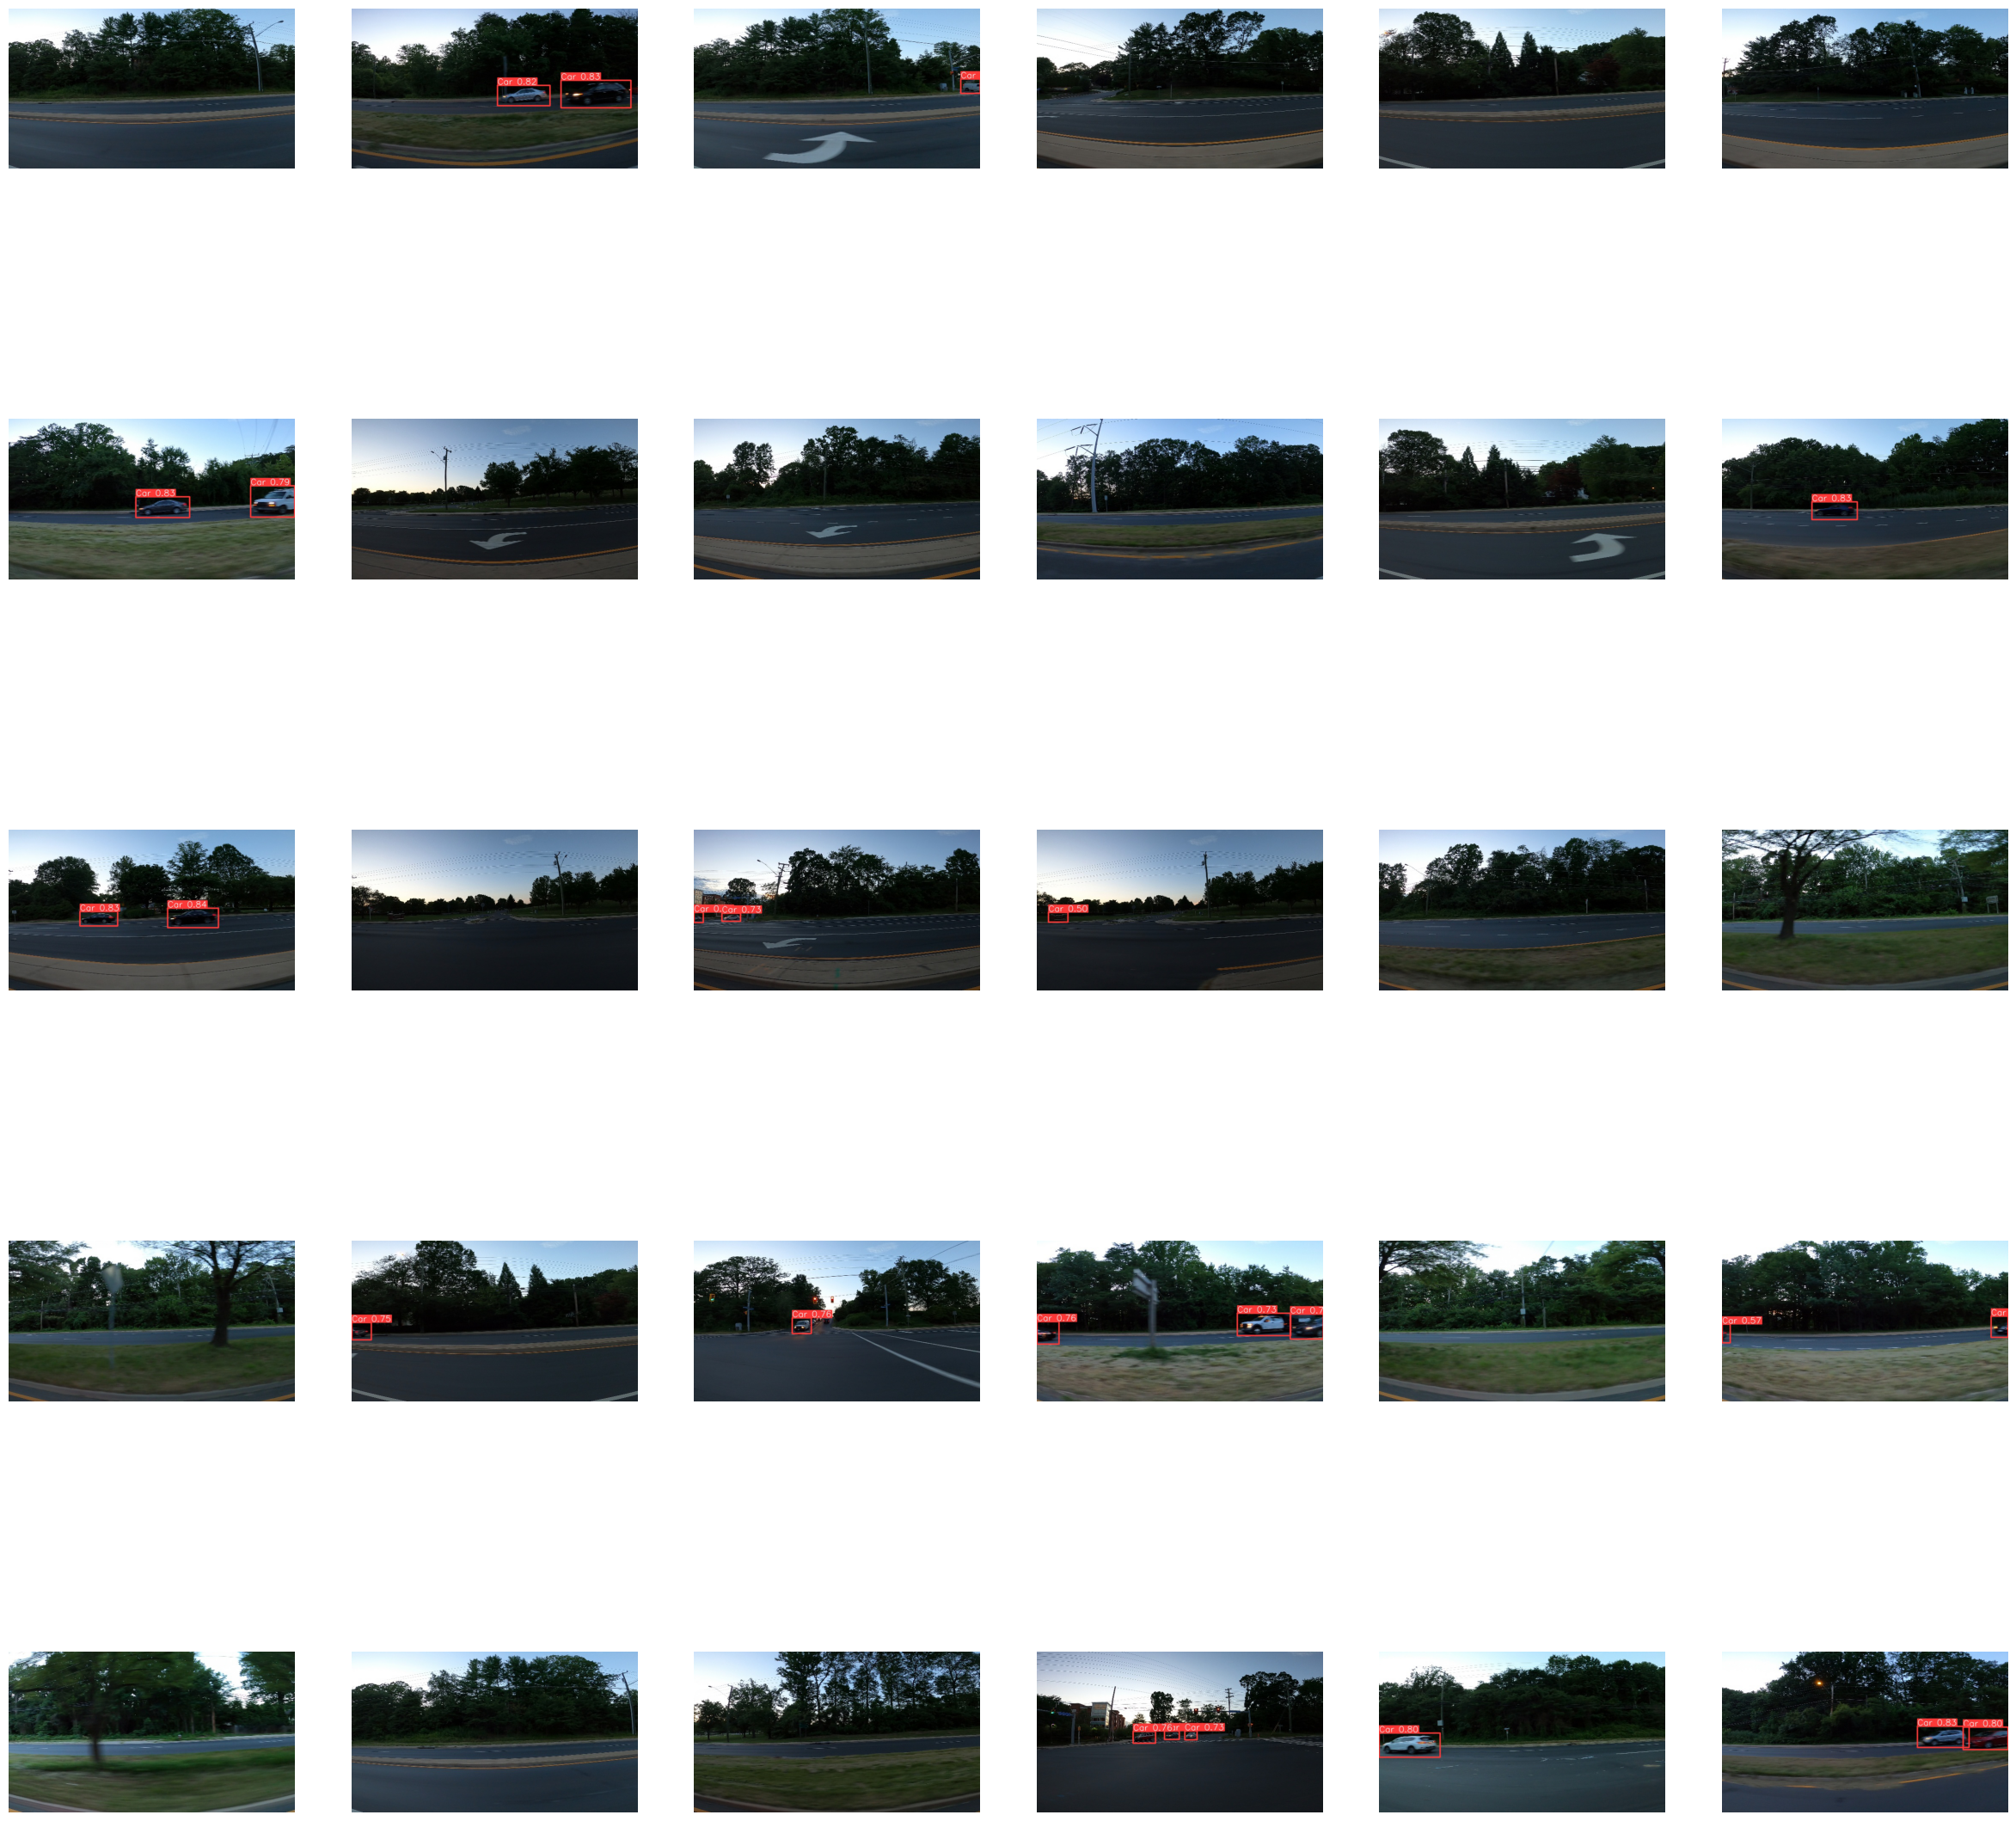

In [ ]:
# Now visualize our test dataset
import os
import matplotlib.pyplot as plt

def visualize(folder_path, num_images, row):
    image_files = os.listdir(folder_path)
    num_images = min(num_images, len(image_files))

    col = (num_images + row - 1) // row  # Calculate the number of columns

    plt.figure(figsize=(30, 30))  # Set the overall figure size

    for i in range(num_images):
        plt.subplot(row, col, i + 1)
        image_path = os.path.join(folder_path, image_files[i])
        image = plt.imread(image_path)
        plt.imshow(image)
        plt.axis('off')

    plt.show()

folder_path = '/content/runs/detect/predict'

visualize(folder_path, 30, 5)

